## __Load Data__

In [32]:
# def filter_errors(df):
#     # 예약시작시간과 반납 동일
#     f1 = df.reservation_start_at.eq(df.reservation_return_at)

#     return df[~f1]

In [33]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
pd.options.display.float_format = '{:.2f}'.format


# 예약id, 차량id 컬럼 및 예약생성시 위치좌표(결측치 3/4가량)컬럼 drop
df = pd.read_csv('../data/socar_reservation_triplog.csv', parse_dates=['reservation_start_at', 'reservation_return_at', 'member_created_date'])
df = df.drop(columns=['reservation_id', 'car_id', 'reservation_created_lat', 'reservation_created_lng'])

In [34]:
df.head()

,member_id_encrypted,region,reservation_return_at,reservation_start_at,member_age,member_gender,member_created_date,member_total_distance,is_vroom,car_name,zone_name,zone_address,zone_lat,zone_lng,zone_type1,zone_type2,zone_type3,trip
0,6qA1i9+DXTJYgfWPqSGhszRpgNkUzFATBTG4XG7OciA=,서울특별시 강서구,2019-01-01 17:33:42,2018-12-31 17:30:00,48,male,2016-12-10,2277.00,False,아반떼AD,SK주차장,서울 강서구 방화동 500-8,37.57,126.80,LIVING_APT,TRANSFER_STATION,TRANSFER_SUBWAY,NaN
1,9uzg+C7Ng5hsI0So4WgJaUME+1dgR1LXyy4c8TEM1zY=,울산광역시 남구,2019-01-01 12:08:55,2018-12-31 16:00:00,25,male,2015-07-06,13156.00,False,스포티지,우정유료주차장,울산 남구 삼산동 1481-10,35.54,129.34,TRANSFER_TERMINAL,TRANSFER_TERMINAL,COMMERCIAL_HOTSPOT,NaN
2,SwEY5le8plfdi3EKoLBAF87zCTzFgIUo4nGWkZ6tOcM=,경기도 김포시,2019-01-02 17:30:00,2019-01-02 14:50:00,34,male,2015-10-07,318.00,True,카니발 11인승,월드애비뉴,경기 김포시 구래동 6880-7,37.65,126.63,LIVING_APT,COMMERCIAL_HOTSPOT,ETC,NaN
3,vmk4kp/a2AYP8VnGWJUYlbSOff+SxEG18D6fqKRkAOk=,경기도 남양주시,2019-01-01 20:53:09,2018-12-31 11:00:00,23,male,2017-10-13,1288.00,False,아반떼AD,제뉴빌딩주차장,경기 남양주시 호평동 642-2,37.65,127.24,LIVING_APT,TRANSFER_SUBWAY,COMMERCIAL_HOTSPOT,NaN
4,gdP+78Hhm+MZ4ZxIm8kNVvMNzKJBxbiDfBsflsMcwLA=,서울특별시 강서구,2019-01-04 14:06:03,2019-01-03 08:00:00,35,male,2017-08-13,2658.00,False,투싼(경유),용정주차장,서울 강서구 방화동 608-9,37.57,126.82,LIVING_ETC,TRANSFER_SUBWAY,ETC,NaN


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751548 entries, 0 to 751547
Data columns (total 18 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   member_id_encrypted    751548 non-null  object        
 1   region                 751548 non-null  object        
 2   reservation_return_at  751548 non-null  datetime64[ns]
 3   reservation_start_at   751548 non-null  datetime64[ns]
 4   member_age             751548 non-null  int64         
 5   member_gender          699017 non-null  object        
 6   member_created_date    751548 non-null  datetime64[ns]
 7   member_total_distance  738010 non-null  float64       
 8   is_vroom               751548 non-null  bool          
 9   car_name               751548 non-null  object        
 10  zone_name              750774 non-null  object        
 11  zone_address           751548 non-null  object        
 12  zone_lat               751548 non-null  floa

In [38]:
# 부름 서비스는 7% 가량
df.is_vroom.mean()

0.0759419225385471

In [39]:
# 2018년 말~ 2019년 말 약 1년간의 데이터
df.sort_values('reservation_start_at')['reservation_start_at'].values[0], \
df.sort_values('reservation_start_at')['reservation_start_at'].values[-1]

(numpy.datetime64('2018-12-25T14:10:00.000000000'),
 numpy.datetime64('2019-11-30T23:30:00.000000000'))

- 총 75만여 행

- 시간 변수: ride 시작 및 반납  timestamp
- 유저 변수: 나이, 성별, 가입일자, 누적주행거리
- 차량 변수: 차종
- 서비스 변수: 부름 여부
- 예약존 변수: 존이름, 주소, 존좌표, 존타입
- Trip 특성: 방문지 (시동 on/off시 지역)

## __1. 유저 단위 분석__

In [40]:
# 멤버id 컬럼명 변경
df = df.rename(columns={'member_id_encrypted':'member_id'})

In [41]:
# 총 22만 7천여명의 멤버 존재
df.member_id.nunique()

227120

count   227120.00
mean         3.31
std          7.07
min          1.00
25%          1.00
50%          1.00
75%          3.00
max        394.00
Name: member_id, dtype: float64

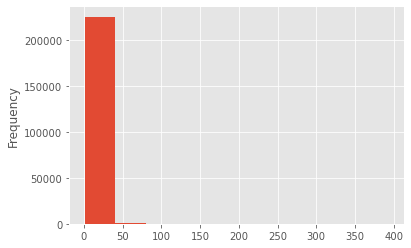

In [42]:
# 멤버별 이용횟수 -> 1회 이용자가 많음
usage_counts = df.member_id.value_counts()
usage_counts.plot(kind='hist')
usage_counts.describe()

<AxesSubplot:ylabel='Frequency'>

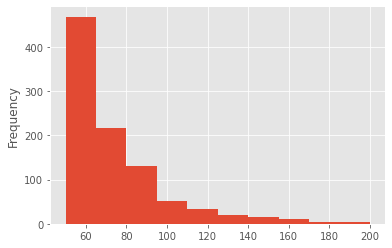

In [43]:
# 50~200회로 범위 제한
usage_counts.plot(kind='hist', range=(50,200))

In [44]:
# 전체 멤버의 57% 가량이 1회 이용자
# 멤버 세분화 필요할 것으로 보임 -> 저/중/고 빈도 멤버에 대해 다른 접근 필요
usage_counts.eq(1).mean()

0.5675810144417048

In [45]:
# 10회(임의설정) 이상 멤버들이 전체 이용의 40% 이상을 수행함

loyal_members = usage_counts[usage_counts.gt(10)].index
print(f'10회이상 이용자 수: {len(loyal_members):,} ({len(loyal_members) *100 / len(usage_counts):.1f}%)')
cnt = df[df.member_id.isin(loyal_members)].shape[0]
print(f'이용 건수: {cnt:,} ({cnt *100 / df.shape[0]:.1f}%)')

10회이상 이용자 수: 13,191 (5.8%)
이용 건수: 313,192 (41.7%)


In [46]:
member_features = [name for name in df.columns if name.startswith('member')]
member_features

['member_id',
 'member_age',
 'member_gender',
 'member_created_date',
 'member_total_distance']

In [47]:
# 나이대 및 가입일, 주행거리 등 수치형 데이터 분포 확인
# member_total_distance로 쏘카 첫 이용자 확인 가능

member_df = df.drop_duplicates('member_id')  # 멤버별 하나의 record 만 남겨 멤버특성 확인
member_df[member_features].describe(datetime_is_numeric=True)

,member_age,member_created_date,member_total_distance
count,227120.00,227120,223748.00
mean,31.12,2017-07-23 05:49:45.248326912,1811.12
min,21.00,2012-02-01 00:00:00,0.00
25%,25.00,2016-05-04 00:00:00,211.00
50%,28.00,2017-09-23 00:00:00,688.00
75%,36.00,2019-01-06 00:00:00,1963.00
max,85.00,2019-11-30 00:00:00,121163.00
std,8.64,NaN,3365.77


<AxesSubplot:ylabel='Frequency'>

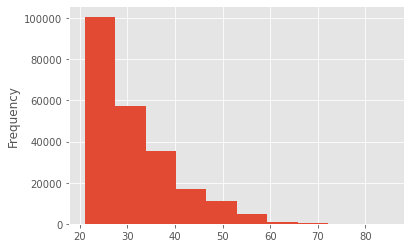

In [48]:
# 나이대 분포
member_df.member_age.plot(kind='hist')

In [49]:
# 3/4 가량이 남성 멤버
member_df.member_gender.value_counts(normalize=True)

male     0.76
female   0.24
Name: member_gender, dtype: float64

## __2. Trip Log__

In [50]:
df.columns

Index(['member_id', 'region', 'reservation_return_at', 'reservation_start_at',
       'member_age', 'member_gender', 'member_created_date',
       'member_total_distance', 'is_vroom', 'car_name', 'zone_name',
       'zone_address', 'zone_lat', 'zone_lng', 'zone_type1', 'zone_type2',
       'zone_type3', 'trip'],
      dtype='object')

In [51]:
# 이용시간 컬럼 생성
df['usage_hour'] = df.reservation_return_at.sub(df.reservation_start_at).map(lambda x: x / np.timedelta64(1, 'h'))

In [52]:
trip_df = df.dropna(subset=['trip']).copy()
usecol = member_features + ['usage_hour', 'zone_address', 'trip']

trip_df = trip_df[usecol]

In [53]:
trip_df.head()

,member_id,member_age,member_gender,member_created_date,member_total_distance,usage_hour,zone_address,trip
5735,1mGAeA7IOfhkzhQFwLxRBgGzPowVDcSQVK2/V8kDMPM=,35,male,2015-04-11,8774.00,79.57,서울 서대문구 대현동 145,"광주광역시 남구,광주광역시 남구,광주광역시 동구,광주광역시 동구,광주광역시 동구,광..."
6295,wbThAF/3/JTlPt/WYFh5smLsm5SiYeHRKUwSdSSTPoU=,35,male,2018-01-27,222.00,34.66,울산 북구 화봉동 1466,"부산광역시 남구,부산광역시 남구,부산광역시 남구,부산광역시 남구,부산광역시 동래구,..."
6297,KkyDio56SwjqcZ7on2ABGMAKLFbEB7hRfcZ4DJ5aBlg=,41,male,2014-11-13,191.00,2.95,서울 동대문구 휘경동 283-5,경기도 구리시
8146,Au2om8v5WY/HEZd81G/gqfWVO14pTUs124HNylTSPjU=,32,female,2015-09-26,19256.00,94.56,서울 강서구 화곡동 98-86,"충청북도 보은군,서울특별시 양천구,강원도 원주시,경상북도 의성군,경상북도 의성군,경..."
10111,KCBn3ApdPczY3rDgOmFRYXMbpX9PgsH/LiAUqp3DJnc=,35,male,2013-07-23,1421.00,22.82,부산 강서구 대저2동 2764-2,부산광역시 사하구


In [54]:
# trip 정보로부터 컬럼 생성
trip_df['num_trip'] = trip_df.trip.str.split(',').map(lambda x: len(x))  # triplog의 수: trip cycle의 수
trip_df['num_regions'] = trip_df.trip.str.split(',').map(lambda x: len(set(x)))  # unique한 방문지의 수

In [55]:
trip_df.head()

,member_id,member_age,member_gender,member_created_date,member_total_distance,usage_hour,zone_address,trip,num_trip,num_regions
5735,1mGAeA7IOfhkzhQFwLxRBgGzPowVDcSQVK2/V8kDMPM=,35,male,2015-04-11,8774.00,79.57,서울 서대문구 대현동 145,"광주광역시 남구,광주광역시 남구,광주광역시 동구,광주광역시 동구,광주광역시 동구,광...",22,9
6295,wbThAF/3/JTlPt/WYFh5smLsm5SiYeHRKUwSdSSTPoU=,35,male,2018-01-27,222.00,34.66,울산 북구 화봉동 1466,"부산광역시 남구,부산광역시 남구,부산광역시 남구,부산광역시 남구,부산광역시 동래구,...",10,5
6297,KkyDio56SwjqcZ7on2ABGMAKLFbEB7hRfcZ4DJ5aBlg=,41,male,2014-11-13,191.00,2.95,서울 동대문구 휘경동 283-5,경기도 구리시,1,1
8146,Au2om8v5WY/HEZd81G/gqfWVO14pTUs124HNylTSPjU=,32,female,2015-09-26,19256.00,94.56,서울 강서구 화곡동 98-86,"충청북도 보은군,서울특별시 양천구,강원도 원주시,경상북도 의성군,경상북도 의성군,경...",22,8
10111,KCBn3ApdPczY3rDgOmFRYXMbpX9PgsH/LiAUqp3DJnc=,35,male,2013-07-23,1421.00,22.82,부산 강서구 대저2동 2764-2,부산광역시 사하구,1,1


In [56]:
trip_df['last_region'] = trip_df.trip.str.split(',').map(lambda x: x[-1])

In [57]:
# 예약존 위치 (zone_address)와 trip log의 첫,마지막 레코드가 일치하지는 않음 (중간 방문지 로그인듯)
trip_df.head()

,member_id,member_age,member_gender,member_created_date,member_total_distance,usage_hour,zone_address,trip,num_trip,num_regions,last_region
5735,1mGAeA7IOfhkzhQFwLxRBgGzPowVDcSQVK2/V8kDMPM=,35,male,2015-04-11,8774.00,79.57,서울 서대문구 대현동 145,"광주광역시 남구,광주광역시 남구,광주광역시 동구,광주광역시 동구,광주광역시 동구,광...",22,9,전라남도 화순군
6295,wbThAF/3/JTlPt/WYFh5smLsm5SiYeHRKUwSdSSTPoU=,35,male,2018-01-27,222.00,34.66,울산 북구 화봉동 1466,"부산광역시 남구,부산광역시 남구,부산광역시 남구,부산광역시 남구,부산광역시 동래구,...",10,5,울산광역시 중구
6297,KkyDio56SwjqcZ7on2ABGMAKLFbEB7hRfcZ4DJ5aBlg=,41,male,2014-11-13,191.00,2.95,서울 동대문구 휘경동 283-5,경기도 구리시,1,1,경기도 구리시
8146,Au2om8v5WY/HEZd81G/gqfWVO14pTUs124HNylTSPjU=,32,female,2015-09-26,19256.00,94.56,서울 강서구 화곡동 98-86,"충청북도 보은군,서울특별시 양천구,강원도 원주시,경상북도 의성군,경상북도 의성군,경...",22,8,서울특별시 양천구
10111,KCBn3ApdPczY3rDgOmFRYXMbpX9PgsH/LiAUqp3DJnc=,35,male,2013-07-23,1421.00,22.82,부산 강서구 대저2동 2764-2,부산광역시 사하구,1,1,부산광역시 사하구


In [58]:
trip_df.describe()

,member_age,member_total_distance,usage_hour,num_trip,num_regions
count,555474.00,544417.00,555474.00,555474.00,555474.00
mean,31.29,4689.23,9.64,2.84,1.72
std,8.65,7011.80,14.00,3.05,1.10
min,21.00,0.00,-16.33,1.00,1.00
25%,25.00,723.00,3.21,1.00,1.00
50%,29.00,2244.00,5.13,2.00,1.00
75%,36.00,5876.00,10.04,3.00,2.00
max,78.00,121163.00,1299.40,251.00,38.00


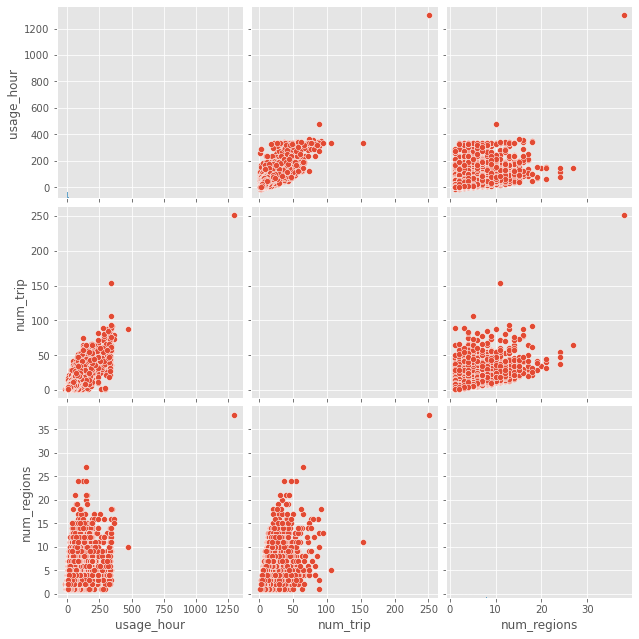

In [59]:
# 사용시간, tripcycle수, 방문지역 수 확인

sns.pairplot(data=trip_df[['usage_hour', 'num_trip', 'num_regions']], height=3)

In [60]:
# 각 컬럼별 상위 1프로 값 제외
cond1 = trip_df.usage_hour.lt(trip_df.usage_hour.quantile(0.99))
cond2 = trip_df.num_trip.lt(trip_df.num_trip.quantile(0.99))
cond3 = trip_df.num_regions.lt(trip_df.num_regions.quantile(0.99))

In [61]:
trip_df[cond1&cond2&cond3].describe()

,member_age,member_total_distance,usage_hour,num_trip,num_regions
count,543834.00,533035.00,543834.00,543834.00,543834.00
mean,31.21,4629.15,8.38,2.57,1.64
std,8.61,6858.89,8.96,2.06,0.89
min,21.00,0.00,-16.33,1.00,1.00
25%,25.00,714.00,3.17,1.00,1.00
50%,29.00,2225.00,5.02,2.00,1.00
75%,36.00,5821.00,9.43,3.00,2.00
max,78.00,121163.00,62.64,14.00,5.00


In [62]:
trip_df

,member_id,member_age,member_gender,member_created_date,member_total_distance,usage_hour,zone_address,trip,num_trip,num_regions,last_region
5735,1mGAeA7IOfhkzhQFwLxRBgGzPowVDcSQVK2/V8kDMPM=,35,male,2015-04-11,8774.00,79.57,서울 서대문구 대현동 145,"광주광역시 남구,광주광역시 남구,광주광역시 동구,광주광역시 동구,광주광역시 동구,광...",22,9,전라남도 화순군
6295,wbThAF/3/JTlPt/WYFh5smLsm5SiYeHRKUwSdSSTPoU=,35,male,2018-01-27,222.00,34.66,울산 북구 화봉동 1466,"부산광역시 남구,부산광역시 남구,부산광역시 남구,부산광역시 남구,부산광역시 동래구,...",10,5,울산광역시 중구
6297,KkyDio56SwjqcZ7on2ABGMAKLFbEB7hRfcZ4DJ5aBlg=,41,male,2014-11-13,191.00,2.95,서울 동대문구 휘경동 283-5,경기도 구리시,1,1,경기도 구리시
8146,Au2om8v5WY/HEZd81G/gqfWVO14pTUs124HNylTSPjU=,32,female,2015-09-26,19256.00,94.56,서울 강서구 화곡동 98-86,"충청북도 보은군,서울특별시 양천구,강원도 원주시,경상북도 의성군,경상북도 의성군,경...",22,8,서울특별시 양천구
10111,KCBn3ApdPczY3rDgOmFRYXMbpX9PgsH/LiAUqp3DJnc=,35,male,2013-07-23,1421.00,22.82,부산 강서구 대저2동 2764-2,부산광역시 사하구,1,1,부산광역시 사하구
...,...,...,...,...,...,...,...,...,...,...,...
751542,X8aIsbFWJdDldihinn7oWYt46MX/OE57k6OSE0VzPOc=,28,male,2017-04-30,704.00,11.40,전북 전주시 완산구 중화산동2가 629-2,"전라북도 완주군,경기도 용인시 기흥구,전라북도 전주시 완산구,전라북도 전주시 덕진구",4,4,전라북도 전주시 덕진구
751544,isNozhU/SlfjlXncrzi20TgQEev2hiSf+JH/13Vzt1Y=,31,male,2018-03-09,10799.00,22.83,경기 의정부시 의정부동 494 센트럴타워,"경기도 양주시,경기도 고양시 일산서구,경기도 양주시,경기도 고양시 일산서구",4,2,경기도 고양시 일산서구
751545,DBVfEBiHB2Fq4PgtorxeD6SKjkvP+yeofER1mjQ6OD0=,28,male,2015-06-10,9080.00,2.66,서울 강남구 대치동 984-12,서울특별시 노원구,1,1,서울특별시 노원구
751546,2akRtQ2yPc0zFkPX1EGe72+tJPXrOhFKHmlOiwiwYY0=,21,male,2016-08-04,932.00,6.99,서울 강서구 화곡동 110-65,"인천광역시 중구,서울특별시 강서구,서울특별시 영등포구,서울특별시 강서구",4,3,서울특별시 강서구


In [70]:
# 여러 x에 대해
# 과거 x기간 동안의 이용 빈도
# 과거 x기간 동안 이용시간의 평균, 표준편차
# 현재로부터 n회 이용을 만족하는 과거 기간

### __예약 주기__

In [91]:
def get_cycle(member_df):
    start_time = member_df.sort_values('reservation_start_at').reservation_start_at
    cycles = start_time[1:].sub(start_time.values[:-1]).divide(np.timedelta64(1, 'D')).values
    return cycles

In [95]:
sample = df[df.member_id.eq(df.member_id.unique()[5000])]

get_cycle(sample)

array([ 1.97222222,  6.00694444,  1.        ,  6.        ,  4.        ,
        0.89583333,  1.18055556,  0.91666667,  1.02777778,  3.40972222,
        1.42361111,  2.06944444,  5.11805556,  0.95833333,  1.08333333,
        0.95138889,  1.04166667,  3.90972222,  2.06944444,  1.92361111,
        6.07638889,  2.02083333,  3.97222222,  4.29166667,  0.375     ,
        0.20138889,  2.95138889,  1.80555556,  0.34027778,  3.05555556,
        1.        ,  2.        ,  0.94444444,  0.83333333,  1.84027778,
        2.38888889,  0.81944444,  0.5       ,  3.06944444,  0.22222222,
        0.34027778,  3.        ,  2.69444444,  4.14583333,  1.02777778,
        1.625     ,  1.18055556,  0.32638889,  1.01388889,  1.97916667,
        4.97222222,  1.04861111,  2.8125    ,  4.66666667,  5.5       ,
        3.04166667,  3.9375    ,  0.68055556,  1.34027778,  5.01388889,
        1.00694444,  1.00694444,  5.        ,  4.01388889,  6.        ,
        1.90972222,  3.07638889,  4.42361111,  3.63194444,  0.95